In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, hstack
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
import numpy as np
from scipy.optimize import curve_fit
import sys
import os
import shutil
import pickle
import math
from scipy.optimize import minimize


from clevar.catalog import ClCatalog
from clevar.match import ProximityMatch
from clevar.match import get_matched_pairs
from clevar.match_metrics import scaling
from clevar.match_metrics import recovery
from clevar.match_metrics import distances
from clevar.match_metrics.recovery import ClCatalogFuncs as r_cf
from clevar.match import output_matched_catalog
import tables_io

## Fitting completeness

In [2]:
matching_selected = 'cross'
##########select case
catalog1 = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/member_matching/fshare_0.1_pref_more_massive/cat2.fits'
catalog2 = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/member_matching/fshare_0.1_pref_more_massive/cat1.fits'
halo_tags = {'id':'halo_id', 'mass':'halo_mass', 'ra':'ra','dec':'dec' ,'z':'redshift_true'}
c1 = ClCatalog.read_full(catalog1)
c2 = ClCatalog.read_full(catalog2)
display(tables_io.read('/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/member_matching/fshare_0.1_pref_more_massive/output_catalog_cl_hl.fits'))

#merged_tags = {'z_cl':'cat1_zp', 'richness': 'cat1_n200', 'z_halo':'cat2_redshift_true', 'log_mass': 'cat2_log_mass', 'm200c': 'cat2_m200c', 'log_m200c': 'cat2_log_m200c'}
merged_tags = {'z_cl':'cat1_zp', 'richness': 'cat1_n200', 'z_halo':'cat2_redshift_true', 'm200c': 'cat2_m200c'}

c_merged_12 = ClCatalog.read('/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/member_matching/fshare_0.1_pref_more_massive/output_catalog_cl_hl.fits', 'merged', tags = merged_tags, full=True)
c_merged_12['log_m200c'] = np.log10(c_merged_12['m200c'])
c2['log_m200c'] = np.log10(c2['m200c'])









    * ClEvar used in matching: 0.17.1
    * ClEvar used in matching: 0.17.1


cat1_id,cat1_ra,cat1_dec,cat1_zp,cat1_n200,cat1_n200_err,cat1_snr,cat1_mt_self,cat1_mt_other,cat1_mt_multi_self,cat1_mt_multi_other,cat1_mt_cross,cat2_halo_id,cat2_ra_true,cat2_dec_true,cat2_redshift_true,cat2_m200c,cat2_NMEM,cat2_NMEM_z_star2,cat2_mt_self,cat2_mt_other,cat2_mt_multi_self,cat2_mt_multi_other,cat2_mt_cross
bytes30,float64,float64,float32,float32,float32,float32,bytes13,bytes13,bytes55,bytes188,bytes13,bytes21,float64,float64,float64,float64,int64,int64,bytes6,bytes6,bytes32,bytes43,bytes6
107736,49.573452898865064,-44.19856875299083,0.90690804,8.524,0.884,3.931,564600185259,564600185259,564600185259,564600185259,564600185259,564600185259,49.58288449966824,-44.22192983893416,0.893551230430603,11930990147785.916,21,8,107736,107736,107736,107736,107736
159266,49.6229232677457,-44.19077801704629,0.59695685,7.742,1.304,3.305,1231400185315,1231400185315,1231400185315,1231400185315,1231400185315,1231400185315,49.62549525779159,-44.201062834379854,0.5724718570709229,16928264111233.803,13,4,159266,159266,159266,159266,159266
71406,49.624166952973546,-44.24813537832407,0.68355304,13.501,2.554,4.562,1201700185293,1201700185293,1201700185293,"1201700185293,1778600185279",1201700185293,1201700185293,49.62852246636445,-44.26087792680184,0.6600160598754883,19661147063887.324,33,9,71406,71406,71406,71406,71406
46063,49.6396988537299,-44.13098009953938,0.2576662,6.448,1.993,5.248,122800185392,122800185392,"122800185392,48100185392","122800185392,48100185392",122800185392,122800185392,49.628954281126575,-44.14116079469193,0.26654016971588135,41368054088833.805,30,12,46063,46063,46063,46063,46063
80898,49.652316087449314,-43.99831698753705,0.4461611,8.318,2.55,4.37,409300185347,409300185347,409300185347,409300185347,409300185347,409300185347,49.65520480638549,-44.00257487107589,0.42746472358703613,32961183144022.535,24,5,80898,80898,80898,80898,80898
59680,49.67318188668861,-43.98271590825951,0.8248326,9.258,0.81,4.839,587200185266,587200185266,587200185266,587200185266,587200185266,587200185266,49.67535969901073,-43.997425318720246,0.8415951728820801,14429627129509.86,21,12,59680,59680,59680,59680,59680
121876,49.69015609126278,-44.319289181763516,0.85703593,5.081,0.999,3.735,1723800185259,1723800185259,1723800185259,1723800185259,1723800185259,1723800185259,49.69083288825692,-44.331221853991025,0.9090408086776733,10265232652259.156,12,8,121876,121876,121876,121876,121876
43708,49.691511479047584,-44.19944339889675,0.8773089,12.231,1.389,5.334,1989900185266,1989900185266,1989900185266,"1105400185272,1989900185266",1989900185266,1989900185266,49.68476477230634,-44.215449830234775,0.8464770317077637,16550865363290.143,20,7,43708,43708,43708,43708,43708
33661,49.731391597997565,-44.37553633877195,0.21579404,10.783,3.02,5.77,148900185401,148900185401,148900185401,148900185401,148900185401,148900185401,49.73505498333092,-44.383923435228354,0.23520994186401367,71026349843470.42,41,12,33661,33661,33661,33661,33661


/pbs/home/e/ebarroso/.local/lib/python3.12/site-packages/clevar-0.17.1-py3.12.egg/clevar/catalog/tagdata.py:308: UserWarning: id column missing, additional one is being created.
  warnings.warn(f"{id_name} column missing, additional one is being created.")
/tmp/ipykernel_204/29833324.py:14: RuntimeWarning: invalid value encountered in log10
  c_merged_12['log_m200c'] = np.log10(c_merged_12['m200c'])
/tmp/ipykernel_204/29833324.py:15: RuntimeWarning: invalid value encountered in log10
  c2['log_m200c'] = np.log10(c2['m200c'])


In [3]:
from clevar.match import get_matched_masks
mt_mask_halo, mt_mask_cluster = get_matched_masks(c2, c1, 'cross')

c2["snr_cl"] = np.repeat(999., len(c2['ra']))
c2["snr_cl"][mt_mask_halo] = c1['snr'][mt_mask_cluster]	

c1["halo_mass"] = 10**18
c1["halo_mass"][mt_mask_cluster] = c2['mass'][mt_mask_halo]

c2["richness_cl"] = 1e6
c2["richness_cl"][mt_mask_halo] = c1['mass'][mt_mask_cluster]

c1["sz"] = np.zeros_like(c1['mass'])
c1["sz"][mt_mask_cluster] = c2['z'][mt_mask_halo]

In [4]:
zcut = (c_merged_12['z_halo'] > 0.05) & (c_merged_12['z_halo'] < 1.07)
c_merged_12 = c_merged_12[zcut]
richcut = (c_merged_12['richness'] > 10)
c_merged_12 = c_merged_12[richcut]
snrcut = (c_merged_12['cat1_snr'] > 6)
c_merged_12 = c_merged_12[snrcut]


zcut = (c2['z'] > 0.05) & (c2['z'] < 1.07)
c2 = c2[zcut]
richcut = (c2['richness'] > 20)
c2 = c2[richcut]
snrcut = (c2['snr_cl'] > 6)
c2 = c2[snrcut]


(array([  54.,  388., 1442., 3115., 4153., 3424., 1329.,  345.,   82.,
           6.]),
 array([12.45325665, 12.7302454 , 13.00723415, 13.28422289, 13.56121164,
        13.83820039, 14.11518914, 14.39217789, 14.66916664, 14.94615539,
        15.22314414]),
 <BarContainer object of 10 artists>)

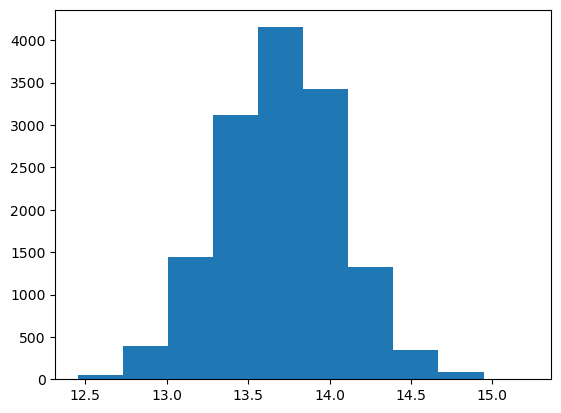

In [5]:
plt.hist(c_merged_12['log_m200c'])

++++++++++++++++Completeness in mass bins
-----0
[0.24557957 0.42381974 0.85454545 0.8       ]
-----1
[0.27829787 0.49497848 0.87040134 0.9266055 ]
-----2
[0.25641277 0.50418457 0.89460477 0.93684211]
[[0.33791749 0.57832618 0.89090909 0.8       ]
 [0.31801418 0.61201066 0.89130435 0.93577982]
 [0.22782455 0.54727437 0.90025094 0.93684211]] [[0.24557957 0.42381974 0.85454545 0.8       ]
 [0.27829787 0.49497848 0.87040134 0.9266055 ]
 [0.25641277 0.50418457 0.89460477 0.93684211]]
[[-0.09233792 -0.15450644 -0.03636364  0.        ]
 [-0.03971631 -0.11703218 -0.02090301 -0.00917431]
 [ 0.02858821 -0.0430898  -0.00564617  0.        ]]
[13.56142096  0.86304243]
[13.55100484  1.14581149]
[13.66146442  1.36907253]


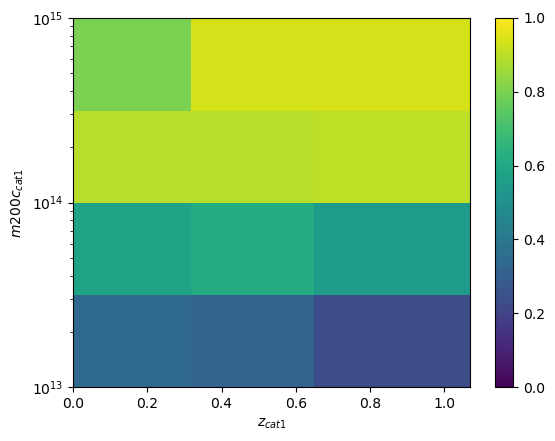

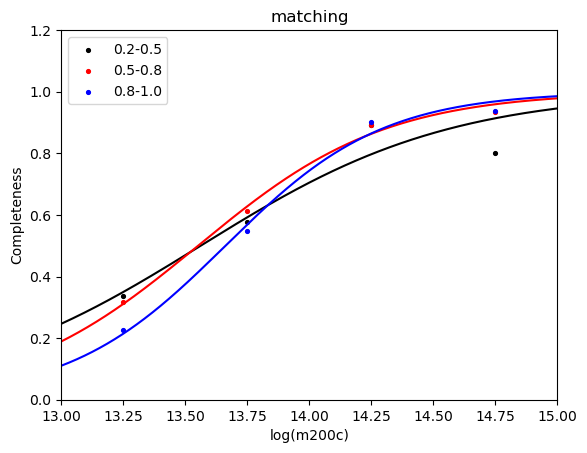

13.56142096123094
0.8630424330762548
13.551004835175949
1.145811488225607
13.661464423234905
1.3690725316231174
[0.16  0.485 0.86 ]
[13.37088071  0.14678093]


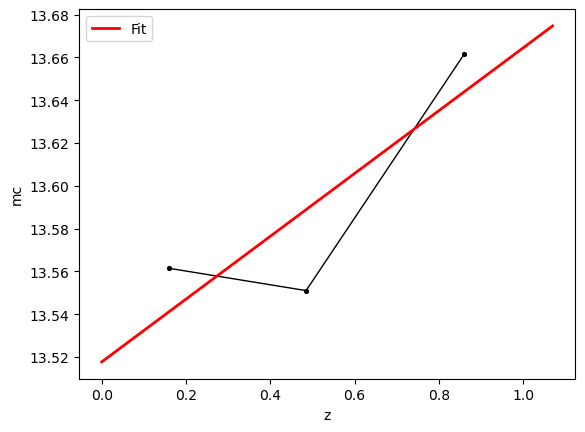

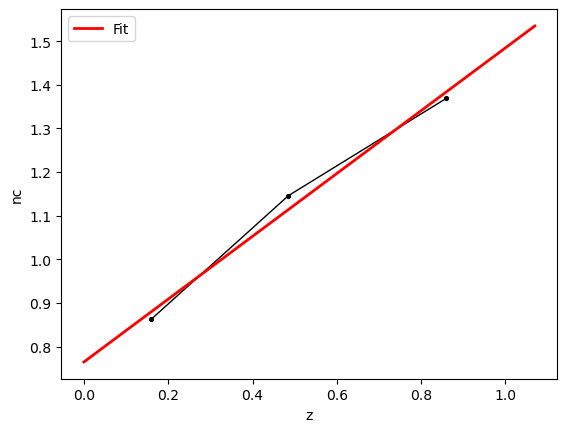

[13.25 13.75 14.25 14.75]
[0.16  0.485 0.86 ]


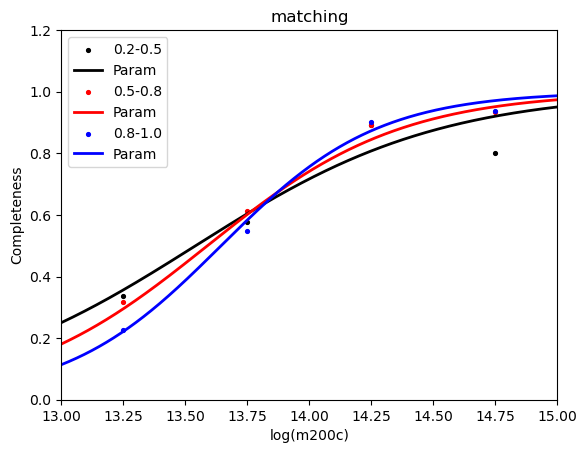

Completeness parametrization: C(log10_m,z_halo) = (log10_m/log10_mc)^nc(z_halo) / ((log10_m/log10_mc)^nc(z_halo) + 1)
nc(z) = a_nc + b_nc*(1+z)
a_nc = 0.0453 +/- 0.0145
b_nc = 0.7197 +/- -0.0093
log10_mc(z) = a_mc + b_mc*(1+z)
a_mc = 13.3709 +/- 0.0205
b_mc = 0.1468 +/- -0.0132


In [6]:
#versus mass
print('++++++++++++++++Completeness in mass bins')
bin_range = [13,15]
nbins_x = 4
zbins = [0.0,0.32, 0.65, 1.07]
mbins = np.logspace(bin_range[0], bin_range[1], nbins_x+1)
nbins_z=len(zbins)-1

compl_m_raw = np.empty([nbins_z,nbins_x])
#Binning inr edshift ann log10mass. CHange for clevar function
for i in range(0,nbins_z):
     print('-----'+str(i))
     cut1 = zbins[i]
     cut2 = zbins[i+1]
     filter1 = np.logical_and(c_merged_12['z_halo'] > cut1, c_merged_12['z_halo'] < cut2)
     c_halos_matched = c_merged_12[filter1]
     #print(c_halos_matched)
     filter2 = np.logical_and(c2['z'] > cut1, c2['z'] < cut2)
     c_halos = c2[filter2]
     #print(c_halos)
     h_r_halos_matched = np.histogram(c_halos_matched['log_m200c'], bins=nbins_x, range=bin_range, weights=None, density=None)
     h_r_halos  = np.histogram(c_halos['log_m200c'], bins=nbins_x, range=bin_range, weights=None, density=None)
     #print(h_r_halos_matched)
     #print(h_r_halos)
     compl_m_raw[i] = np.divide(h_r_halos_matched[0],h_r_halos[0],where=(h_r_halos[0]!=0))
     print(compl_m_raw[i])
info = r_cf.plot2D(c2, col1='z', col2='m200c', bins1=zbins, bins2=mbins,
        matching_type='cross', scale2='log')
print(info['data']['recovery'], compl_m_raw)
print(np.array(compl_m_raw - np.array(info['data']['recovery'])))
compl_m_raw = info['data']['recovery']
## Completeness function
def f_completeness_param_2(log10m,log10_mc,nc):
          return np.exp(nc*np.log(10)*(log10m-log10_mc))/(1+np.exp(nc*np.log(10)*(log10m-log10_mc)))

## Empty coloumns with the size of the binning
arr_log10_mc = np.empty(nbins_z)
arr_nc = np.empty(nbins_z)
bin_x = np.empty([nbins_x])

x_bins = np.linspace(bin_range[0],bin_range[1],nbins_x+1)
labels=['0.2-0.5','0.5-0.8','0.8-1.0','1.0-1.2', '2']
colors=['black','red','blue','purple', 'purple']
#labels=['0.2-0.4','0.4-0.6','0.6-0.8','0.8-1.0','1.0-1.2']
#colors=['black','red','blue','purple','brown']

## Mean value in the mass bin
for ix in range(nbins_x):
     bin_x[ix] = 0.5 * (x_bins[ix] + x_bins[ix+1])
    
plt.figure()
x = np.linspace(13., 15., 2000)

## Fitting the completeness first two values
for i in range(0,nbins_z):
     plt.scatter(bin_x, compl_m_raw[i], label=labels[i], color=colors[i], marker= ".", s=30)
     #plt.plot(bin_x, compl_m_raw[i], color=colors[i])
     ## function evalueated on the middel of mass bins, for a redshift bin in the for loop.
     popt, pcov = curve_fit(f_completeness_param_2, xdata=bin_x, ydata=compl_m_raw[i], p0=[13.5,2])
     print(popt)
     arr_log10_mc[i]=popt[0]
     arr_nc[i]=popt[1]
     f_completeness_param_2_fit = f_completeness_param_2(x, popt[0], popt[1])
     plt.plot(x, f_completeness_param_2_fit, color=colors[i])
     #plt.plot(x, f_completeness_param_2_fit, color=colors[i], linewidth=2.0,label="Param")

plt.ylim(0, 1.2)
plt.xlim(13,15)
plt.xlabel('log(m200c)')
plt.ylabel('Completeness')
plt.title('matching')
plt.legend()
plt.show()
plt.close()

for i in range(0,nbins_z):
     print(arr_log10_mc[i])
     print(arr_nc[i])

bin_x1=np.empty([nbins_z])
for ix1 in range(nbins_z):
     bin_x1[ix1] = 0.5 * (zbins[ix1] + zbins[ix1+1])
print(bin_x1)
def f_lin_z(z,a,b):
     return a + b*(1+z)
x = np.linspace(0.0, 1.07, 2000)

#summary plot for mc(z)
plt.figure()
plt.scatter(bin_x1, arr_log10_mc[:], label="", color= "black",marker= ".", s=30)
plt.plot(bin_x1, arr_log10_mc[:], color= "black", linewidth=1)
popt, pcov = curve_fit(f_lin_z, xdata=bin_x1, ydata=arr_log10_mc, p0=[13,0.5])
print(popt)
a_mc=popt[0]
b_mc=popt[1]
err_a_mc=pcov[0,0]
err_b_mc=pcov[0,1]
f_lin_z_fit_mc = f_lin_z(x, a_mc, b_mc)
plt.plot(x, f_lin_z_fit_mc, color='red', linewidth=2.0,label="Fit")
plt.xlabel('z')
plt.ylabel('mc')
plt.legend()
plt.show()

#summary plot for nc(z)
plt.figure()
plt.scatter(bin_x1, arr_nc[:], label="", color= "black",marker= ".", s=30)
plt.plot(bin_x1, arr_nc[:], color= "black", linewidth=1)
popt, pcov = curve_fit(f_lin_z, xdata=bin_x1, ydata=arr_nc, p0=[13,0.5])
a_nc=popt[0]
b_nc=popt[1]
err_a_nc=pcov[0,0]
err_b_nc=pcov[0,1]
f_lin_z_fit_nc = f_lin_z(x, a_nc, b_nc)
plt.plot(x, f_lin_z_fit_nc, color='red', linewidth=2.0,label="Fit")
plt.xlabel('z')
plt.ylabel('nc')
plt.legend()
plt.show()

#do completeness plots for this parametrization
plt.figure()
x = np.linspace(13, 15, 2000)
print(bin_x)
print(bin_x1)
for i in range(0,nbins_z):
     plt.scatter(bin_x, compl_m_raw[i], label=labels[i], color=colors[i], marker= ".", s=30)
     #plt.plot(bin_x, compl_m_raw[i], color=colors[i])
     log10_mc = f_lin_z(bin_x1[i],a_mc,b_mc)
     nc = f_lin_z(bin_x1[i],a_nc,b_nc)
     f_completeness_param_2_fit = f_completeness_param_2(x, log10_mc, nc)
     plt.plot(x, f_completeness_param_2_fit, color=colors[i], linewidth=2.0,label="Param")
plt.ylim(0, 1.2)
plt.xlim(13,15)
plt.xlabel('log(m200c)')
plt.ylabel('Completeness')
plt.title('matching')
plt.legend()
plt.show()

plt.close()
###print results
a_nc=round(a_nc,4)
err_a_nc=round(err_a_nc,4)
b_nc=round(b_nc,4)
err_b_nc=round(err_b_nc,4)
a_mc=round(a_mc,4)
err_a_mc=round(err_a_mc,4)
b_mc=round(b_mc,4)
err_b_mc=round(err_b_mc,4)
print('Completeness parametrization: C(log10_m,z_halo) = (log10_m/log10_mc)^nc(z_halo) / ((log10_m/log10_mc)^nc(z_halo) + 1)')
print('nc(z) = a_nc + b_nc*(1+z)')
print('a_nc = ' + str(a_nc) + ' +/- ' + str(err_a_nc))
print('b_nc = ' + str(b_nc) + ' +/- ' + str(err_b_nc))
print('log10_mc(z) = a_mc + b_mc*(1+z)')
print('a_mc = ' + str(a_mc) + ' +/- ' + str(err_a_mc))
print('b_mc = ' + str(b_mc) + ' +/- ' + str(err_b_mc))

## Mass richness fit

In [7]:
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats

def obs_value(p, mass, z, pivot_mass, log1p_pivot_redshift):
    """Return observed quantity corrected by redshift and mass."""
    ln_mass = np.log(mass)
    delta_ln_mass = ln_mass - pivot_mass
    delta_z = np.log1p(z) - log1p_pivot_redshift
    return p[0] + p[1] * delta_ln_mass + p[2] * delta_z

def richness(x_list, p0, p1, p2, s0, s1, s2):
    """Compute log-likelihood of the richness model instead of sampling."""
    pivot_mass = 31.562846748652873
    pivot_redshift = 0.73
    log1p_pivotz = 0.5481214085096875
    
    mean_values = []
    sigma_values = []
    
    for mass, z in zip(x_list[0], x_list[1]):
        mean_value = obs_value([p0, p1, p2], mass, z, pivot_mass, log1p_pivotz)
        sigma_value = np.exp(obs_value([s0, s1, s2], mass, z, pivot_mass, log1p_pivotz))  # Ensure positive sigma
        
        mean_values.append(mean_value)
        sigma_values.append(sigma_value)
    
    return np.array(mean_values), np.array(sigma_values)

def objective_function(params, xdata, ydata):
    """Compute the log-likelihood for curve fitting."""
    p0, p1, p2, s0, s1, s2 = params
    mean_values, sigma_values = richness(xdata, p0, p1, p2, s0, s1, s2)
    
    # Compute log-likelihood instead of random sampling
    log_likelihood = stats.norm.logpdf(ydata, loc=mean_values, scale=sigma_values)
    
    return -np.sum(log_likelihood)  # Minimize negative log-likelihood

# Prepare data
xdata = (np.array(c_merged_12['m200c']), np.array(c_merged_12['z_cl']))
ydata = np.log(np.array(c_merged_12['richness']))

# Initial guesses
p0 = [np.mean(ydata), 1.5, 0.1, 0.8, 0.05, -0.05]

# Minimize negative log-likelihood
from scipy.optimize import minimize

result = minimize(
    objective_function, 
    p0, 
    args=(xdata, ydata),
    method="L-BFGS-B"  # Stable optimizer
)

popt = result.x
print("Optimized parameters:", popt)


Optimized parameters: [ 2.95492604  0.29292171  0.57309566 -1.03856096  0.34019105  0.07658556]


## Firecrown Prediction

In [8]:
from firecrown.models.cluster.recipes.murata_binned_spec_z_completeness import MurataBinnedSpecZRecipe as MDS
from firecrown.models.cluster.abundance import ClusterAbundance
from firecrown.models.cluster.abundance import ClusterAbundance
from firecrown.models.cluster.properties import ClusterProperty
from firecrown.likelihood.binned_cluster_number_counts import BinnedClusterNumberCounts
from firecrown.models.cluster.mass_proxy import MurataBinned
import sacc
import pyccl as ccl
import numpy as np
from firecrown.modeling_tools import ModelingTools


In [12]:
def compare_prediction(path, survey_nm, pivot_mass, pivot_redshift, mu_p0, mu_p1, mu_p2, sigma_p0, sigma_p1, sigma_p2, mass_parameter=False):
    s_read = sacc.Sacc.load_fits(path)

    
    hmf = ccl.halos.MassFuncBocquet16(mass_def = '200c')
    min_mass, max_mass = 13., 16.
    min_z, max_z = 0.2, 0.8
    cluster_abundance = ClusterAbundance((min_mass, max_mass), (min_z, max_z), hmf)
    cosmo_ccl = ccl.Cosmology(
    Omega_c=0.22,
    Omega_b=0.0448,
    h=0.71,
    n_s=0.963,
    sigma8=0.8,
    Omega_k=0.0,
    Neff=3.044,
    m_nu=0.0,
    w0=-1.0,
    wa=0.0,
    T_CMB=2.7255
    )
    cluster_abundance.update_ingredients(cosmo_ccl)
    
    modeling_tools = ModelingTools(cluster_abundance=cluster_abundance)
    mds = MDS()
    mds.mass_distribution.pivot_mass = pivot_mass
    mds.mass_distribution.pivot_redshift = pivot_redshift
    mds.mass_distribution.log1p_pivot_redshift = np.log1p(pivot_redshift)
    mds.mass_distribution.mu_p0 = mu_p0
    mds.mass_distribution.mu_p1 = mu_p1
    mds.mass_distribution.mu_p2 = mu_p2
    mds.mass_distribution.sigma_p0 = sigma_p0
    mds.mass_distribution.sigma_p1 = sigma_p1
    mds.mass_distribution.sigma_p2 = sigma_p2
    mds.completeness_distribution.ac_nc = -2.0899#a_nc#-0.373#0.6466
    mds.completeness_distribution.bc_nc = 2.10816#b_nc#0.23#0.969
    mds.completeness_distribution.ac_mc = 12.90715#a_mc#14.31#14.4736
    mds.completeness_distribution.bc_mc = 0.43828#b_mc#1.2#-0.2834

    average_on = ClusterProperty.COUNTS
    if mass_parameter:
        average_on |= ClusterProperty.MASS
    bin_cl_theory = BinnedClusterNumberCounts(average_on, survey_nm, mds)
    bin_cl_theory.read(s_read)
    cluster_abundance.update_ingredients(cosmo_ccl)

    prediction = bin_cl_theory._compute_theory_vector(modeling_tools)
    data = bin_cl_theory.data_vector
    print(prediction, data, np.array(prediction)/np.array(data))
    return prediction


In [13]:
sdss_sacc = "/sps/lsst/users/ebarroso/CLPipeline/examples/wazp_DC2/outputs_20_richness/clusters_sacc_file_cov.sacc"
sdss_survey_name = "dc2_wazp"
mu_p0, mu_p1, mu_p2, sigma_p0, sigma_p1, sigma_p2 = 3.375, np.log(10) * 0.12958, 0.105, 0.13618, np.log(10) * 0.03787, -0.01685
pivot_mass = 31.562846748652873
pivot_redshift = 0.73
pred_sdss = compare_prediction(sdss_sacc, sdss_survey_name, pivot_mass, pivot_redshift, mu_p0, mu_p1, mu_p2, sigma_p0, sigma_p1, sigma_p2, mass_parameter=False)
print(np.log(10) * 0.12958, np.log(10) * 0.03787)

[1.28038553e+03 2.78840888e+03 1.73829503e+03 4.57476298e+02
 2.23443188e+03 8.39442144e+03 1.10087068e+04 7.76842432e+03
 1.76600830e+02 6.86763649e+02 9.75160279e+02 8.38608350e+02
 6.51563420e+00 1.99287315e+01 2.07883656e+01 1.30325182e+01
 1.07684252e-01 2.39696164e-01 1.68623947e-01 6.88981476e-02] [ 525 2323 3966 3937  227 1001 1653 2544  106  321  421  559   31   63
   66   80    2    8   10    7] [2.43882958e+00 1.20034820e+00 4.38299301e-01 1.16199212e-01
 9.84331226e+00 8.38603540e+00 6.65983472e+00 3.05362591e+00
 1.66604556e+00 2.13945062e+00 2.31629520e+00 1.50019383e+00
 2.10181748e-01 3.16329071e-01 3.14975236e-01 1.62906478e-01
 5.38421261e-02 2.99620205e-02 1.68623947e-02 9.84259252e-03]
0.29836897635016846 0.08719889747168452


In [ ]:
import sys
sys.path.insert(0, '/pbs/home/e/ebarroso/gcr-catalogs')
import GCRCatalogs